# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`


## What is demoed

This notebook shows how to create an executor directly.  However, an easier more client friendly facade is available and given in the *mnist* notebook.

Also see the the *debug* notebook, which demostrates how to debug a model.

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

from zensols.deeplearn import TorchConfig
# set the random seed so things are predictable
TorchConfig.set_random_seed()

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn.result import ModelResultGrapher

# configure logging
logging.basicConfig(format='%(asctime)-15s %(name)s [%(levelname)s]: %(message)s',
                    level=logging.WARNING)
for name in ['zensols.deeplearn.result',
             'zensols.deeplearn.model.facade',
             'zensols.deeplearn.batch.stash']:
    logging.getLogger(name).setLevel(logging.INFO)

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 1 (11.1%)
        test: 2 (22.2%)
        train: 6 (66.7%)
        total: 9
    total this instance: 9
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation is `_create_model`, and not meant to be called by the client.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor._create_model())

IrisNetwork(
  (fc): DeepLinear(
    (seq_layers): Sequential(
      (0): Linear(in_features=4, out_features=5, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=5, out_features=1, bias=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1, out_features=3, bias=True)
      (5): Dropout(p=0.1, inplace=False)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

2020-06-27 16:10:54,745 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2020-06-27 16:10:54,748 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2020-06-27 16:10:54,752 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2020-06-27 16:10:54,755 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2020-06-27 16:10:54,759 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2020-06-27 16:10:54,762 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2020-06-27 16:10:56,869 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
train: 8.114|valid: 5.261/3.489 /\: 100%|██████| 15/15 [00:00<00:00, 54.22it/s]
2020-06-27 16:10:57,174 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-06-27 16:10:57,175 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s


Name: Iris: 1
Run index: 2
Learning rate: 0.1
    train:
        started: 06/27/2020 16:10:56:874533
        ended: 06/27/2020 16:10:57:151818
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 14/15
        ave/min loss: 7.18044/2.50566
        accuracy: 0.673 (76/113)
        micro: F1: 0.673, precision: 0.673, recall: 0.673
        macro: F1: 0.632, precision: 0.696, recall: 0.679
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 14/15
        ave/min loss: 3.48851/3.48851
        accuracy: 0.750 (9/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
    test:
        started: 06/27/2020 16:10:57:178595
        ended: 06/27/2020 16:10:57:180174
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 4.50519/2.13488
        accuracy: 0.640 (16/25)
        micro: F1: 0.640, precis

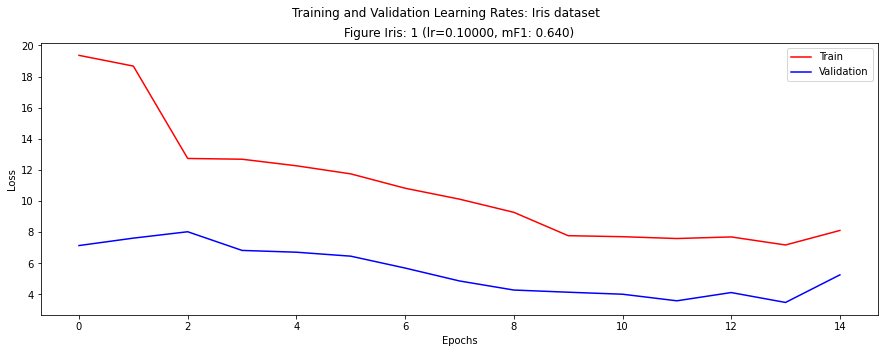

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Create the model facade

An easier wasy to use the executor is with a *facade*.  A `ModelFacade` provides easy to use client entry points to the model executor, which trains, validates, tests, saves and loads the model.  Create the facade with a factory, which in turn creates the executor.  The statistics on the data set that is configured on the executor is, by default, printed to standard out.  You can set the `writer` property to `None` on the facade to disable this.

In [6]:
from dataclasses import dataclass
from zensols.deeplearn.model import ModelFacade

@dataclass
class IrisModelFacade(ModelFacade):
    def _configure_debug_logging(self):
        super()._configure_debug_logging()
        logging.getLogger('iris.model').setLevel(logging.DEBUG)
        
# deallocate the previous executor
executor.deallocate()
# create the facade
facade = IrisModelFacade(config)

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the facade.  In fact, the purpose of the facade is to make changes easily such as this.

Notice that the facade prints the output with a correctly configured scroll bar by default.  Output can be disabled by setting the `writer` attribute/initializer parameter to `None`.  The progress bar and columns are set with the `progress_bar` and `progress_bar_col` attributes.

In [7]:
# set the number of epochs and learning rate, which are both model parameters
facade.epochs = 30
facade.learning_rate = .01

# train and test the model
facade.train()
facade.test()

2020-06-27 16:10:57,504 zensols.deeplearn.model.facade [INFO]: creating new executor
2020-06-27 16:10:57,519 zensols.deeplearn.model.facade [INFO]: training...
2020-06-27 16:10:57,523 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2020-06-27 16:10:57,527 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2020-06-27 16:10:57,530 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2020-06-27 16:10:57,534 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2020-06-27 16:10:57,537 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2020-06-27 16:10:57,540 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2020-06-27 16:10:57,548 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
train: 12.023|valid: 6.886/6.975 \/:  20%|█▏    | 6/30 [00:00<00:00, 56.07it/s]

model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 1 (11.1%)
        test: 2 (22.2%)
        train: 6 (66.7%)
        total: 9
    total this instance: 9
    keys consistent: True


train: 9.851|valid: 5.015/5.078 \/: 100%|██████| 30/30 [00:00<00:00, 45.32it/s]
2020-06-27 16:10:58,240 zensols.deeplearn.model.facade [INFO]: trained in 0s
2020-06-27 16:10:58,250 zensols.deeplearn.model.facade [INFO]: testing...
2020-06-27 16:10:58,254 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-06-27 16:10:58,256 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
2020-06-27 16:10:58,259 zensols.deeplearn.model.facade [INFO]: trained in 0s


Name: Iris: 1
Run index: 2
Learning rate: 0.01
    train:
        started: 06/27/2020 16:10:57:552082
        ended: 06/27/2020 16:10:58:214496
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 29/30
        ave/min loss: 9.70528/5.17343
        accuracy: 0.602 (68/113)
        micro: F1: 0.602, precision: 0.602, recall: 0.602
        macro: F1: 0.496, precision: 0.426, recall: 0.612
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 30/30
        ave/min loss: 5.01544/5.01544
        accuracy: 0.750 (9/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
    test:
        started: 06/27/2020 16:10:58:258044
        ended: 06/27/2020 16:10:58:259426
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 5.81564/1.73373
        accuracy: 0.680 (17/25)
        micro: F1: 0.680, preci

iris.model.IrisNetwork (2)

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

2020-06-27 16:10:58,289 zensols.deeplearn.model.facade [INFO]: training...
train: 5.819|valid: 2.943/2.719 /\: 100%|██| 1000/1000 [00:18<00:00, 52.80it/s]
2020-06-27 16:11:17,755 zensols.deeplearn.model.facade [INFO]: trained in 19s
2020-06-27 16:11:18,004 zensols.deeplearn.model.facade [INFO]: testing...
2020-06-27 16:11:18,008 zensols.deeplearn.model.facade [INFO]: trained in 0s
2020-06-27 16:11:18,009 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 06/27/2020 16:10:58:292133
        ended: 06/27/2020 16:11:17:230495
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 919/1000
        ave/min loss: 5.29254/2.46816
        accuracy: 0.903 (102/113)
        micro: F1: 0.903, precision: 0.903, recall: 0.903
        macro: F1: 0.901, precision: 0.903, recall: 0.904
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 615/1000
        ave/min loss: 2.71876/2.71876
        accuracy: 1.000 (12/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        started: 06/27/2020 16:11:18:006195
        ended: 06/27/2020 16:11:18:008728
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 3.73291/0.91853
        accuracy: 0.880 (22/25)
        micro: F1: 0.8

2020-06-27 16:11:18,597 zensols.deeplearn.result.domain [INFO]: dumping text results to ../target/iris/results/data-4.txt
2020-06-27 16:11:18,943 zensols.deeplearn.result.plot [INFO]: saving results graph to ../target/iris/results/graph-4.png


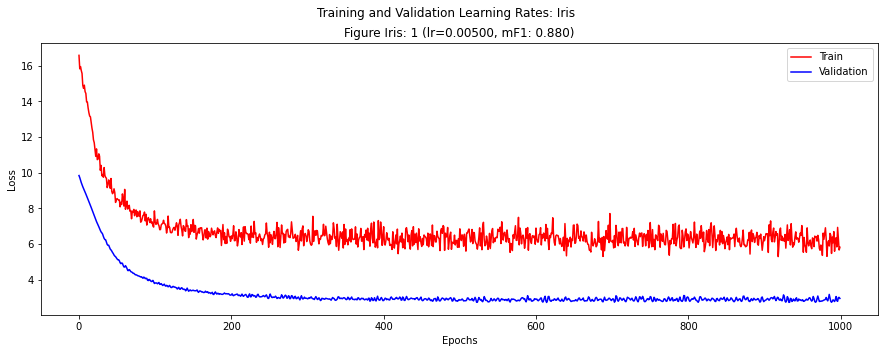

In [8]:
# turn off output so we can get just the final results later with `write_results`
facade.writer = None
# set network parameter `dropout` and model settings to achieve better performance
facade.dropout = 0.1
facade.epochs = 1000
facade.learning_rate = .005
# train and test again
facade.train()
facade.test()
# display the results in this cell
facade.write_results()
# now since we like our results, save them to disk
facade.persist_results()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [9]:
# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.iteritems()))
    return (s,)
facade.get_predictions(transform=map_data_point)

2020-06-27 16:11:19,249 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-06-27 16:11:19,260 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s


,id,label,pred,correct,data
0,17,setosa,setosa,True,"sepal_length=5.1, sepal_width=3.5, petal_lengt..."
1,30,setosa,setosa,True,"sepal_length=4.8, sepal_width=3.1, petal_lengt..."
2,31,setosa,setosa,True,"sepal_length=5.4, sepal_width=3.4, petal_lengt..."
3,33,setosa,setosa,True,"sepal_length=5.5, sepal_width=4.2, petal_lengt..."
4,41,setosa,setosa,True,"sepal_length=4.5, sepal_width=2.3, petal_lengt..."
5,43,setosa,setosa,True,"sepal_length=5.0, sepal_width=3.5, petal_lengt..."
6,45,setosa,setosa,True,"sepal_length=4.8, sepal_width=3.0, petal_lengt..."
7,46,setosa,setosa,True,"sepal_length=5.1, sepal_width=3.8, petal_lengt..."
8,48,setosa,setosa,True,"sepal_length=5.3, sepal_width=3.7, petal_lengt..."
9,49,setosa,setosa,True,"sepal_length=5.0, sepal_width=3.3, petal_lengt..."
